#Install Libraries

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218921 sha256=51d255587b01c8d41b79bf82938b195b879decea4133a2bcbe04c2fae1143e18
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#Import utility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import data import libraries
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import pandas_ta as pta

#Import data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#Import DL libraries
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, Dropout,Bidirectional, Input, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Import Data

In [ ]:
base_stock = "^NSEI"

In [ ]:
df = pdr.get_data_yahoo(base_stock , start="1980-02-01", end="2022-07-13")

[*********************100%***********************]  1 of 1 completed


#Feature Selection

##What aer the different features we can use, keep in mind we want to solve the problem of scaling and predict tomorrow's price

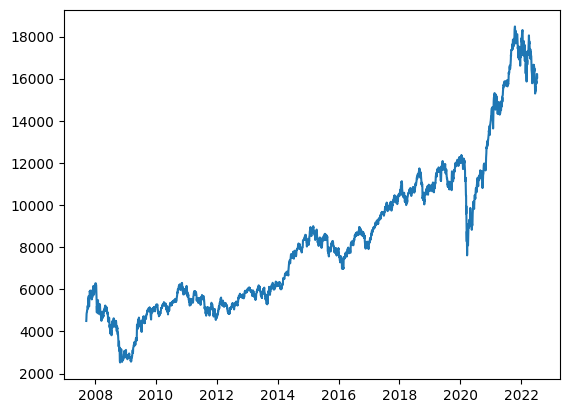

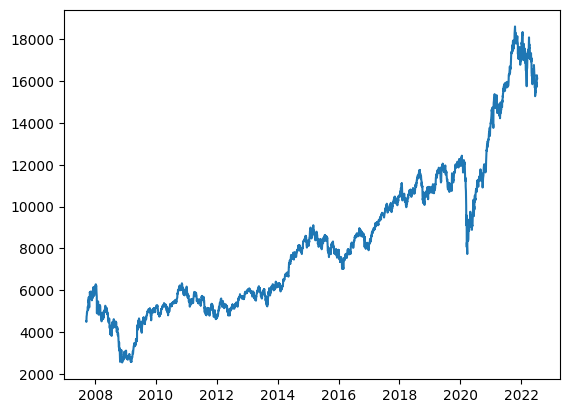

In [ ]:
plt.plot(df['Close'])
plt.show()
plt.plot(df['Open'])
plt.show()

In [ ]:
df['target'] = np.where(df['Open'].shift(-1)>df['Close'], 1, 0)
df

,Open,High,Low,Close,Adj Close,Volume,target
Date,,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0,0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0,1
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0,1
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0,1
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0,0
...,...,...,...,...,...,...,...
2022-07-06,15818.200195,16011.349609,15800.900391,15989.799805,15989.799805,288400,1
2022-07-07,16113.750000,16150.500000,16045.950195,16132.900391,16132.900391,264600,1
2022-07-08,16273.650391,16275.500000,16157.900391,16220.599609,16220.599609,281100,0


In [ ]:
feature = np.array(df[['Open', 'Close', 'target']])

print(feature.shape)

import math

training_data_len = math.ceil(feature.shape[0] *0.8)
print(training_data_len)
training_data = feature[:training_data_len]
testing_data = feature[training_data_len:]
print(training_data.shape, testing_data.shape)

(3630, 3)
2904
(2904, 3) (726, 3)


In [ ]:
batches_training = []
targets_training = []

for i in range(30,len(training_data)):
    buffer_array = list(training_data[i-30:i, :-1])
    targets_training.append(training_data[i-1][2])
    batches_training.append(buffer_array)

print(np.array(batches_training).shape, np.array(targets_training).shape)

(2874, 30, 2) (2874,)


In [ ]:
#Define batch scaling function
scaled_training_data = []
scaled_training_targets = []

def scale(x):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  new_seq = []
  for j in seq_x:
    buffer_seq = []
    for k in j:
      new_k = (k-min_x)/(max_x-min_x)
      buffer_seq.append(new_k)
    new_seq.append(buffer_seq)
  return new_seq

for i in range(0, len(batches_training)):
  seq = batches_training[i]
  buffer_target = targets_training[i]
  new_seq = scale(seq)
  scaled_training_data.append(new_seq)
  scaled_training_targets.append(buffer_target)

x_train = np.array(scaled_training_data)
y_train = np.array(scaled_training_targets)

print(np.array(scaled_training_data).shape, np.array(scaled_training_targets).shape)

(2874, 30, 2) (2874,)


##Model Architecture

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25, activation = 'tanh'))
model.add(Dense(units=1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')
## epochs = 9
history = model.fit(x_train, y_train, batch_size=256, epochs=25, validation_split=0.2)

Epoch 1/25
9/9 [==============================] - 8s 249ms/step - loss: 0.6754 - val_loss: 0.6012
Epoch 2/25
9/9 [==============================] - 2s 258ms/step - loss: 0.6669 - val_loss: 0.6247
Epoch 3/25
9/9 [==============================] - 2s 187ms/step - loss: 0.6674 - val_loss: 0.6196
Epoch 4/25
9/9 [==============================] - 1s 138ms/step - loss: 0.6667 - val_loss: 0.6119
Epoch 5/25
9/9 [==============================] - 1s 137ms/step - loss: 0.6669 - val_loss: 0.6128
Epoch 6/25
9/9 [==============================] - 1s 140ms/step - loss: 0.6669 - val_loss: 0.6171
Epoch 7/25
9/9 [==============================] - 1s 136ms/step - loss: 0.6669 - val_loss: 0.6198
Epoch 8/25
9/9 [==============================] - 1s 140ms/step - loss: 0.6666 - val_loss: 0.6136
Epoch 9/25
9/9 [==============================] - 1s 135ms/step - loss: 0.6670 - val_loss: 0.6124
Epoch 10/25
9/9 [==============================] - 1s 141ms/step - loss: 0.6674 - val_loss: 0.6116
Epoch 11/25
9/9 [==

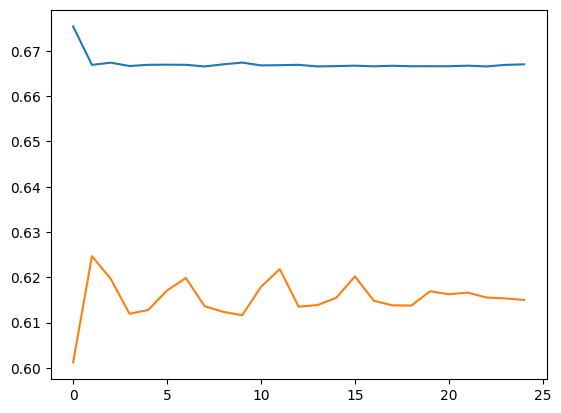

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
batches_testing = []
targets_testing = []

for i in range(30,len(testing_data)):
    buffer_array = list(testing_data[i-30:i, :-1])
    targets_testing.append(testing_data[i-1][2])
    batches_testing.append(buffer_array)

print(np.array(batches_testing).shape, np.array(targets_testing).shape)

(696, 30, 2) (696,)


In [ ]:
#Define batch scaling function
scaled_testing_data = []
scaled_testing_targets = []



def scale(x):
  seq_x = np.array(x)
  max_x = np.amax(seq_x)
  min_x = np.amin(seq_x)
  new_seq = []
  for j in seq_x:
    buffer_seq = []
    for k in j:
      new_k = (k-min_x)/(max_x-min_x)
      buffer_seq.append(new_k)
    new_seq.append(buffer_seq)
  return new_seq


for i in range(0, len(batches_testing)):
  seq = batches_testing[i]
  buffer_target = targets_testing[i]
  new_seq = scale(seq)
  scaled_testing_data.append(new_seq)
  scaled_testing_targets.append(buffer_target)

print(np.array(scaled_testing_data).shape, np.array(scaled_testing_targets).shape)

(696, 30, 2) (696,)


In [ ]:
x_test = np.array(scaled_testing_data)
y_test = np.array(scaled_testing_targets)

print(x_test.shape, y_test.shape)

(696, 30, 2) (696,)


In [ ]:
preds = model.predict(x_test)


22/22 [==============================] - 1s 12ms/step


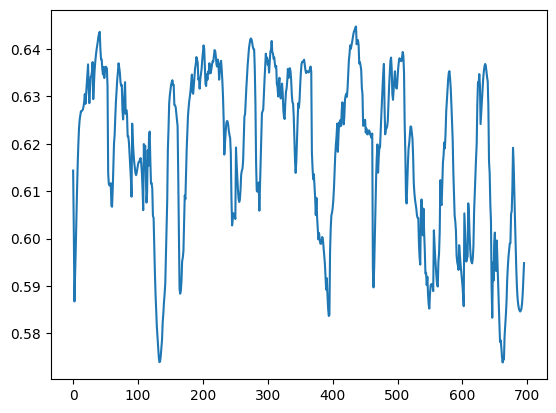

In [ ]:
import matplotlib.pyplot as plt

plt.plot(preds)

In [ ]:
pred_list = []

for pred in preds:
  if pred > 0.5:
    pred_list.append(1)
  else:
    pred_list.append(0)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(pred_list, y_test))
print(accuracy_score(pred_list, y_test))

[[  0   0]
 [216 480]]
0.6896551724137931
